In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import seaborn as sns

logging.basicConfig(level=logging.INFO)
sns.set_context('talk')

# Import Data

In [3]:
from scipy.io import loadmat

sampling_frequency = 1500

data = loadmat('Jaq_epoch4_theta_epochs.mat', squeeze_me=True)
time = data['LFP_rt_dat']
lfp = data['LFPgnd_data']
theta_filtered_lfp = data['theta_filtered_lfp']
tail_velocity = data['tail_velocity']
cam_rt_fit_smoothed = data['cam_rt_fit_smoothedCopy']

In [4]:
lfp[np.isnan(lfp)] = 0.0

In [5]:
THETA_BAND = (6, 12)
TIME_WINDOW_STEP = TIME_WINDOW_DURATION = 0.300
TIME_HALFBANDWIDTH_PRODUCT = 1

# Examine Spectrum

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.3, time_window_step=0.3,
           detrend_type='constant', start_time=4318.5744, n_tapers=1)
/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcPara

frequency resolution = 3.3333333333333335


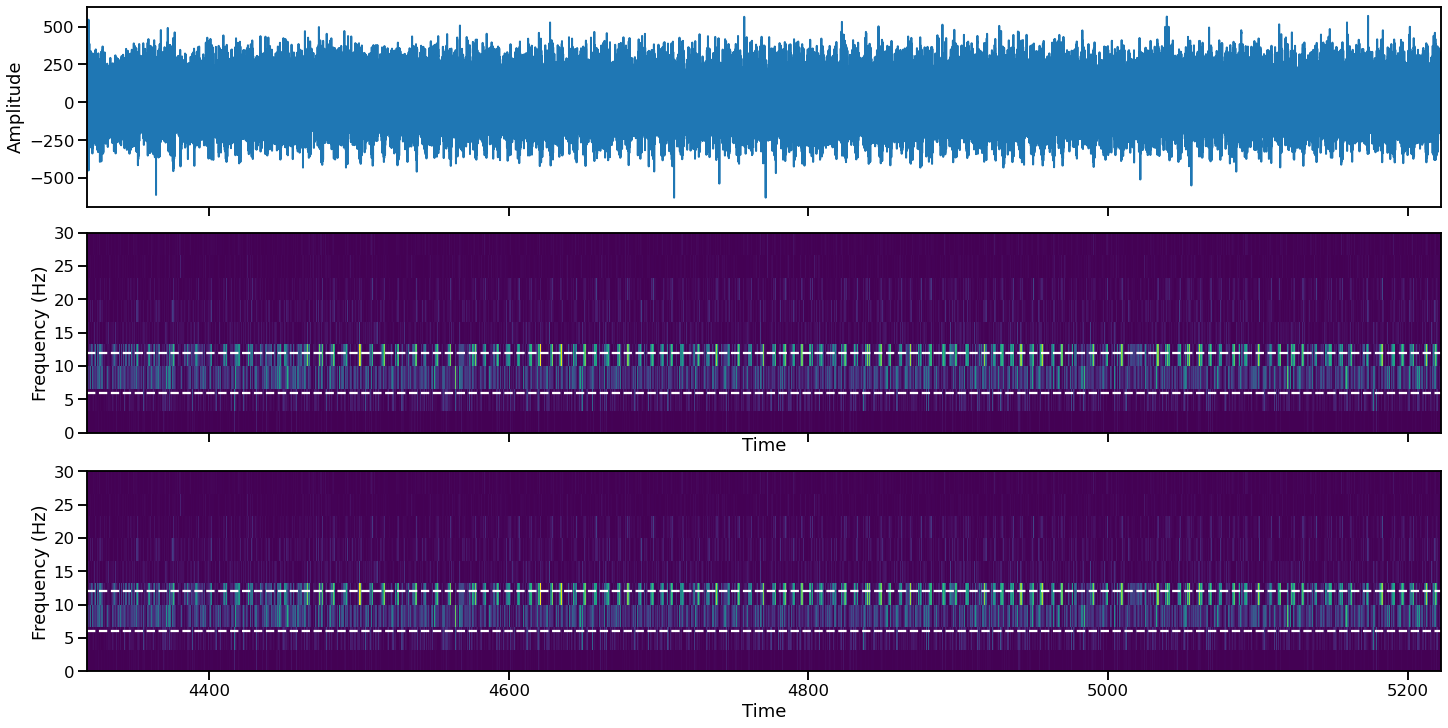

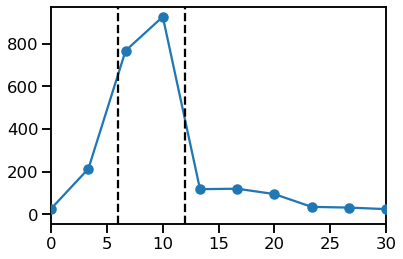

In [6]:
from spectral_connectivity import Multitaper, Connectivity

fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, constrained_layout=True)
axes[0].plot(time, lfp, linewidth=2)
axes[0].set_xlim((time.min(), time.max()))
axes[0].set_ylabel('Amplitude')
    
m = Multitaper(lfp, sampling_frequency=sampling_frequency,
               time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
               time_window_duration=TIME_WINDOW_DURATION,
               time_window_step=TIME_WINDOW_STEP,
               start_time=time.min())
c = Connectivity.from_multitaper(m)
power = c.power().squeeze()

norm_power = power / power.mean()

t, f = np.meshgrid(c.time, c.frequencies)

axes[1].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time')
axes[1].set_ylim((0, 30));
axes[1].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[1].axhline(THETA_BAND[1], linestyle='--', color='white')

axes[2].pcolormesh(t, f, norm_power.T, vmin=norm_power.min(), vmax=norm_power.max())
axes[2].set_ylabel('Frequency (Hz)')
axes[2].set_xlabel('Time')
axes[2].set_ylim((0, 30));
axes[2].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[2].axhline(THETA_BAND[1], linestyle='--', color='white')

print(f'frequency resolution = {m.frequency_resolution}')

plt.figure()
plt.plot(c.frequencies, power.mean(axis=0)); plt.xlim((0, 30));
plt.scatter(c.frequencies, power.mean(axis=0), zorder=10); plt.xlim((0, 30));
plt.axvline(THETA_BAND[0], color='black', linestyle='--')
plt.axvline(THETA_BAND[1], color='black', linestyle='--');

# Detect Theta

In [7]:
from spectral_rhythm_detector import detect_spectral_rhythm


multitaper_params = dict(
    time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
    time_window_duration=TIME_WINDOW_DURATION,
    time_window_step=TIME_WINDOW_STEP,
    start_time=time.min()
)

df, model = detect_spectral_rhythm(
    time, lfp, sampling_frequency,
    multitaper_params=multitaper_params,
    frequency_band=THETA_BAND)

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.3, time_window_step=0.3,
           detrend_type='constant', start_time=4318.5744, n_tapers=1)


In [8]:
model

GaussianHMM(covariance_type='full', n_components=2, n_iter=100,
            startprob_prior=array([-3.60436534e+01, -2.22044605e-16]),
            tol=1e-06)

In [9]:
df.head()

probability  is_spectral_rhythm
time                                         
4318.574400  4.575670e-36               False
4318.575067  1.544000e-14               False
4318.575733  3.088000e-14               False
4318.576400  4.632000e-14               False
4318.577067  6.176001e-14               False

In [10]:
from scipy.ndimage import label

df['label'], _ = label(df.is_spectral_rhythm)

df.head()

probability  is_spectral_rhythm  label
time                                                
4318.574400  4.575670e-36               False      0
4318.575067  1.544000e-14               False      0
4318.575733  3.088000e-14               False      0
4318.576400  4.632000e-14               False      0
4318.577067  6.176001e-14               False      0

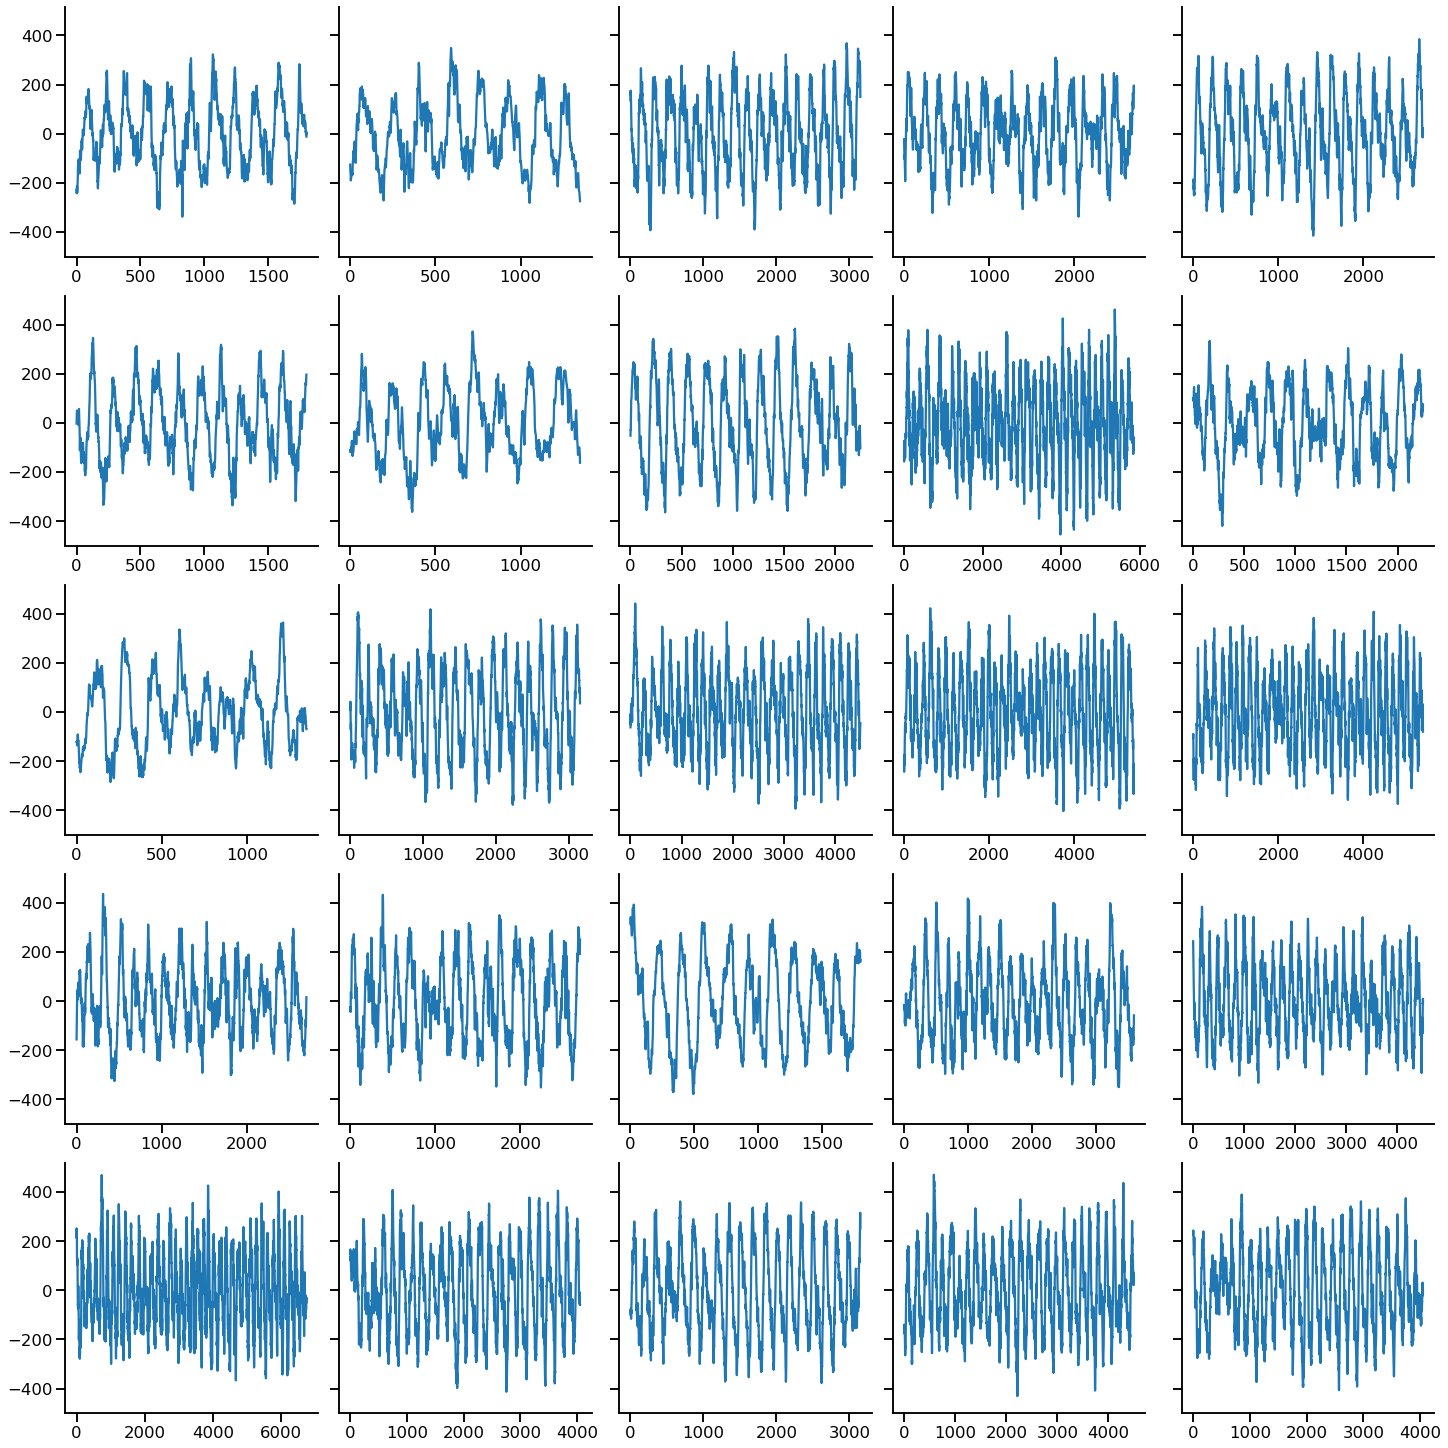

In [11]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20), constrained_layout=True, sharey=True)


for ind, ax in enumerate(axes.flat):
    ax.plot(lfp[df.label == ind+1])
sns.despine()

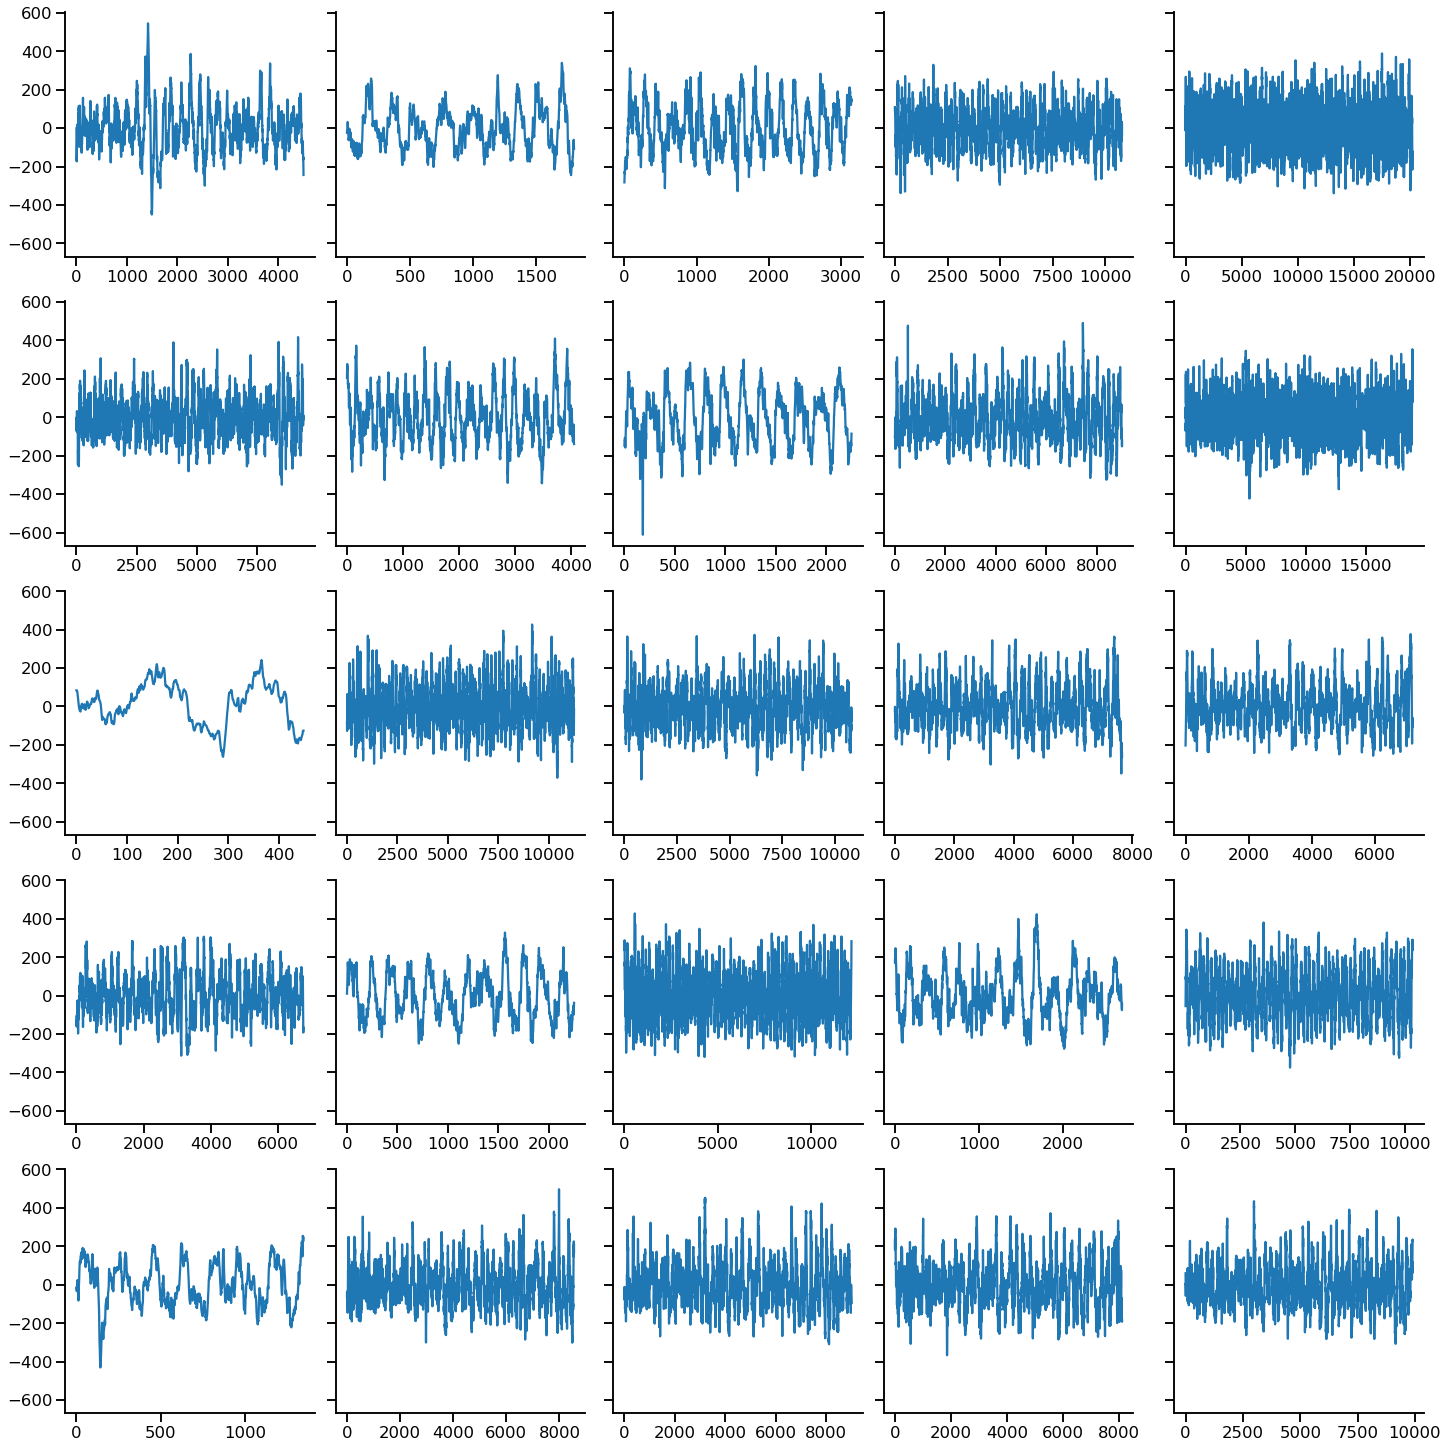

In [12]:
not_theta_label, n_labels = label(~df.is_spectral_rhythm)
fig, axes = plt.subplots(5, 5, figsize=(20, 20), constrained_layout=True, sharey=True)


for ind, ax in enumerate(axes.flat):
    ax.plot(lfp[not_theta_label == ind+1])
sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


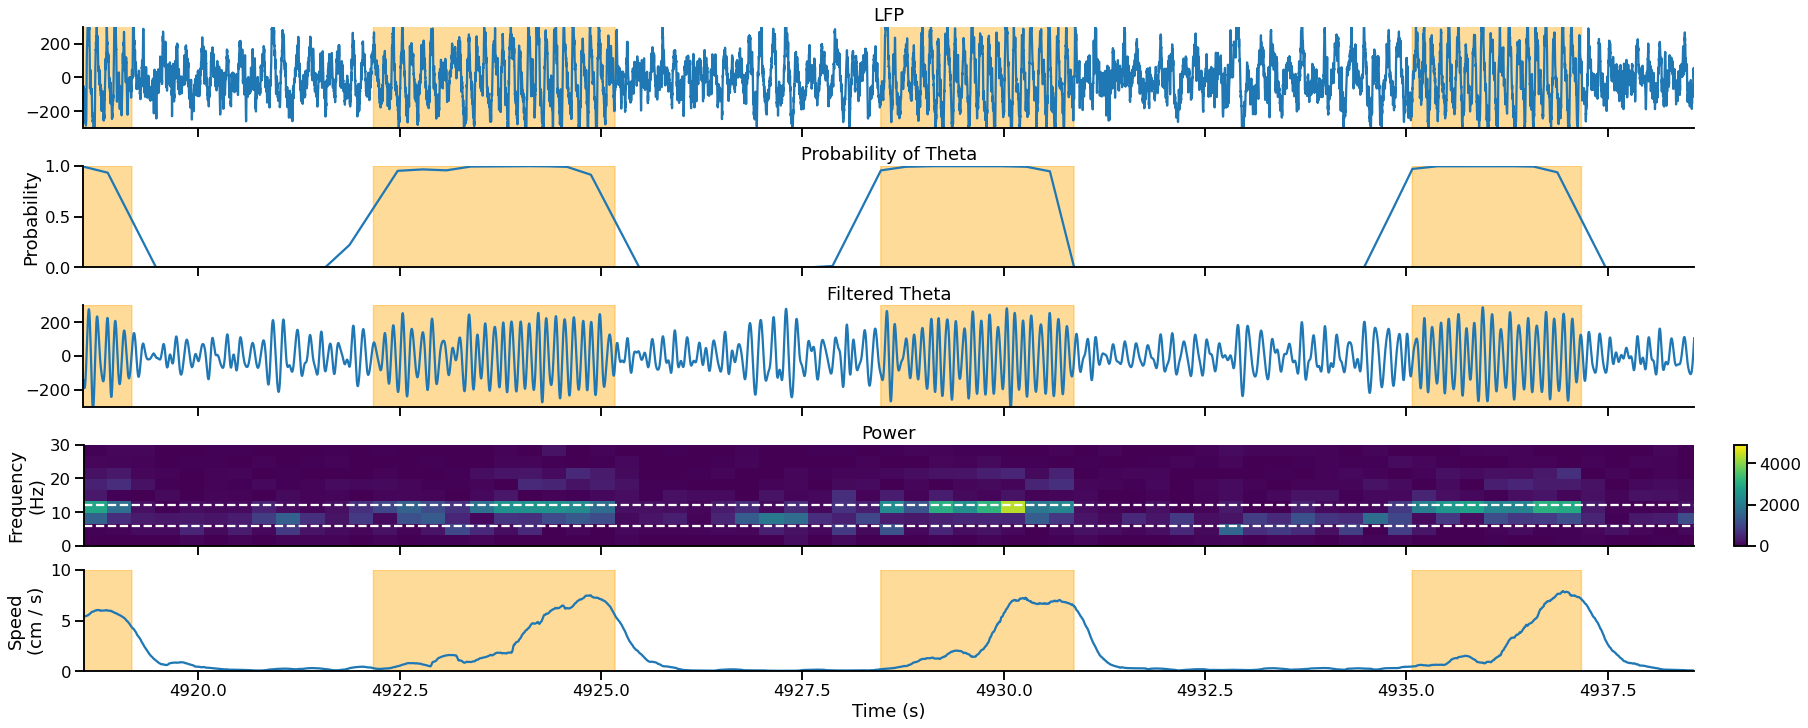

In [13]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 600.0, time.min() + 620.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


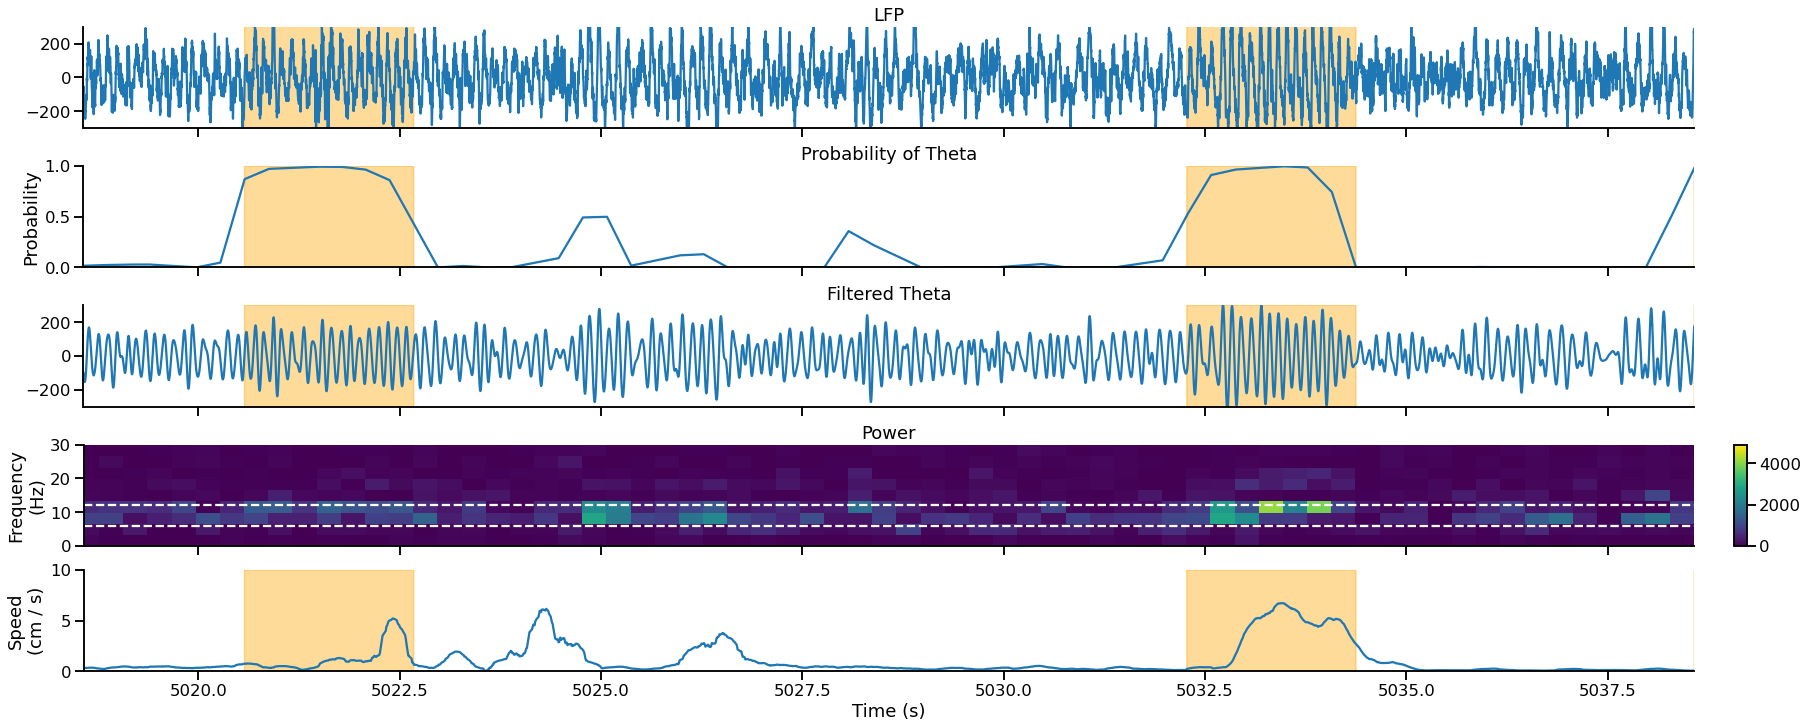

In [14]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 700.0, time.min() + 720.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


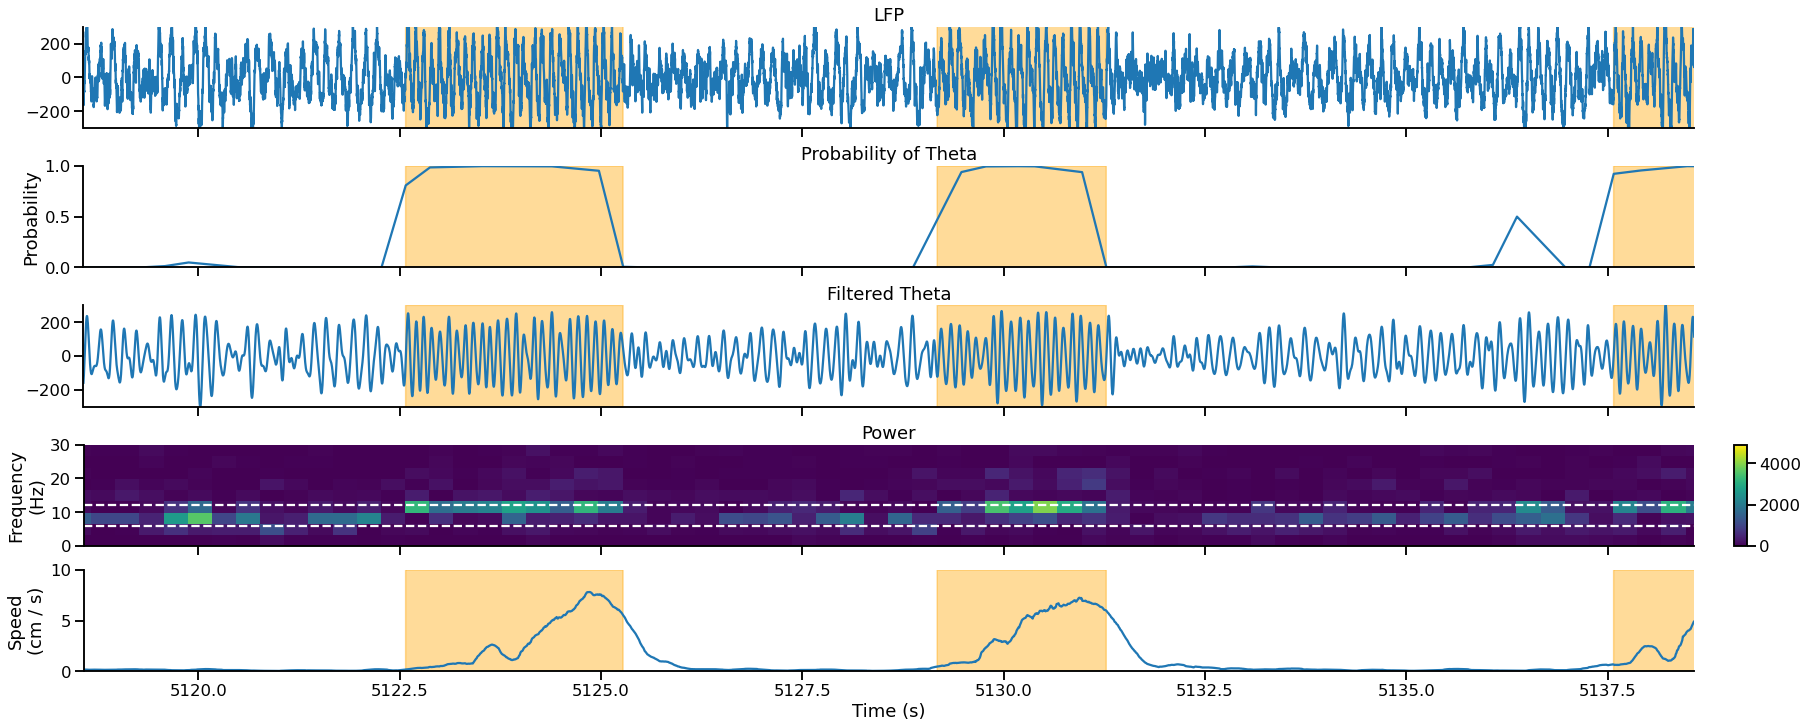

In [15]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 800.0, time.min() + 820.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


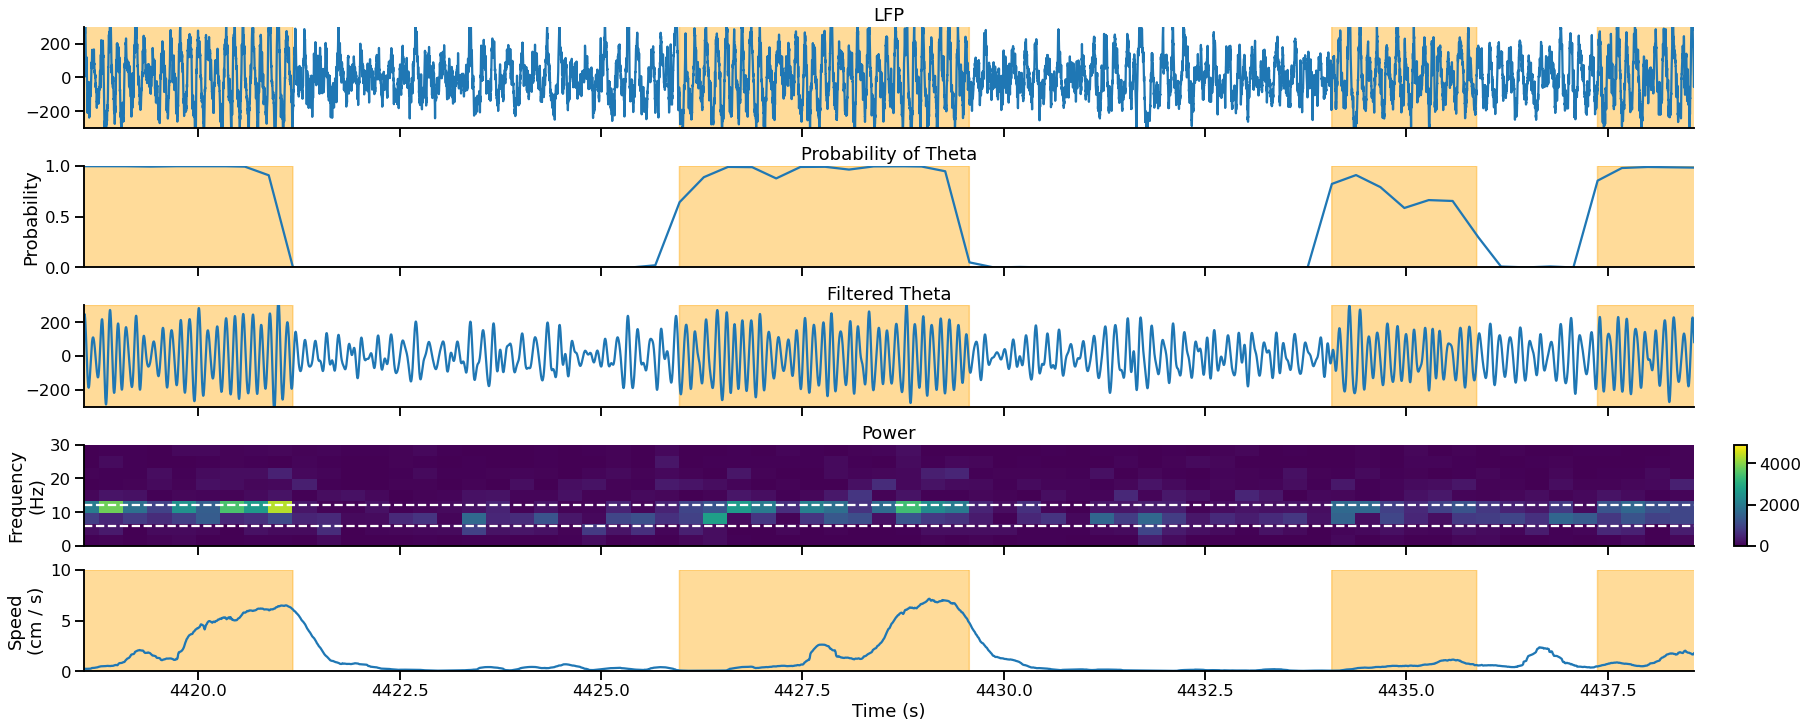

In [16]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 100.0, time.min() + 120.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


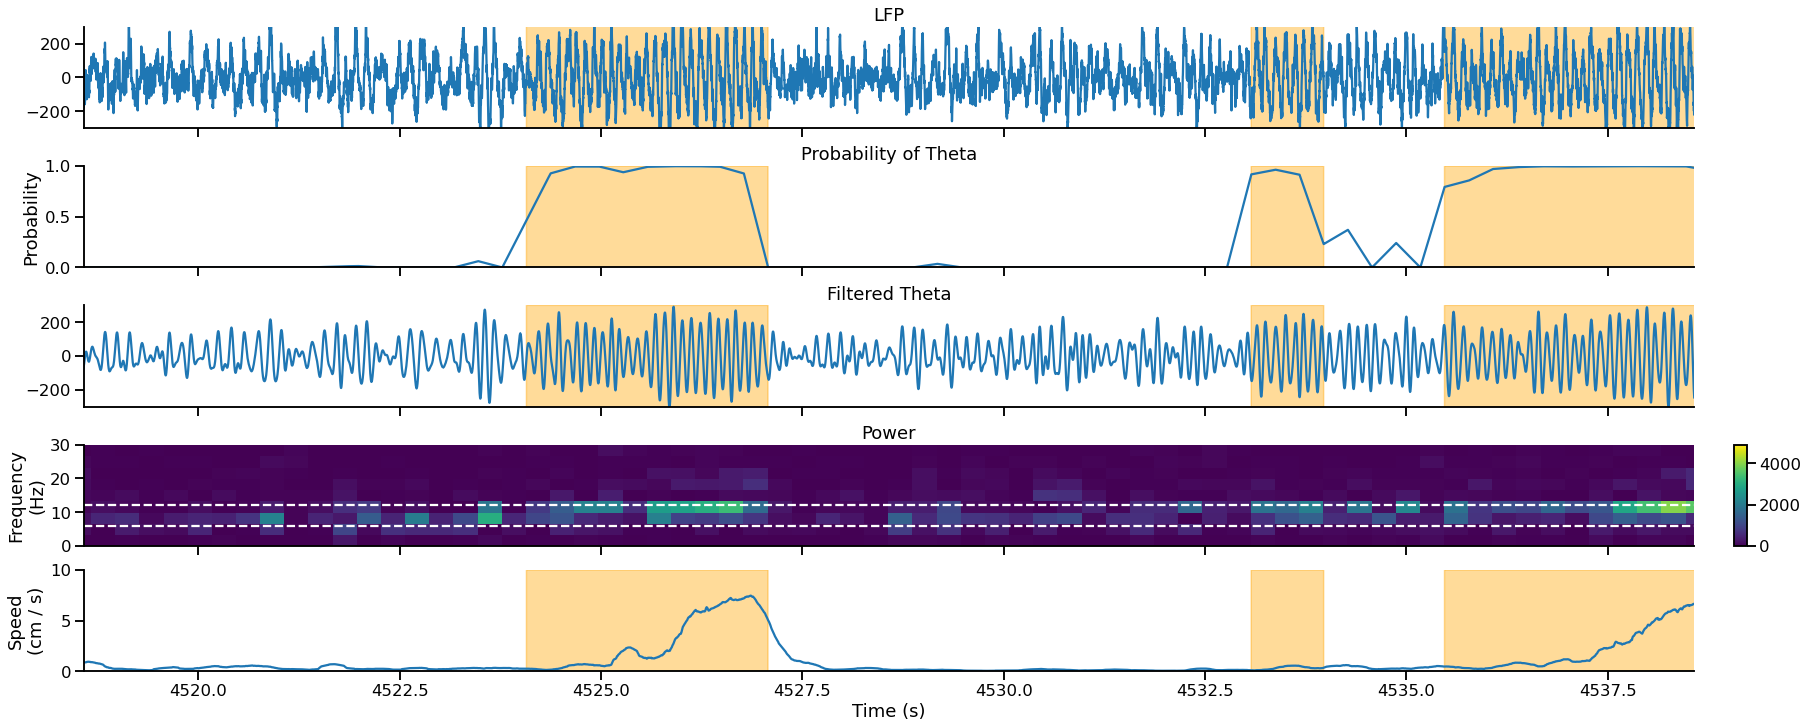

In [17]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 200.0, time.min() + 220.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


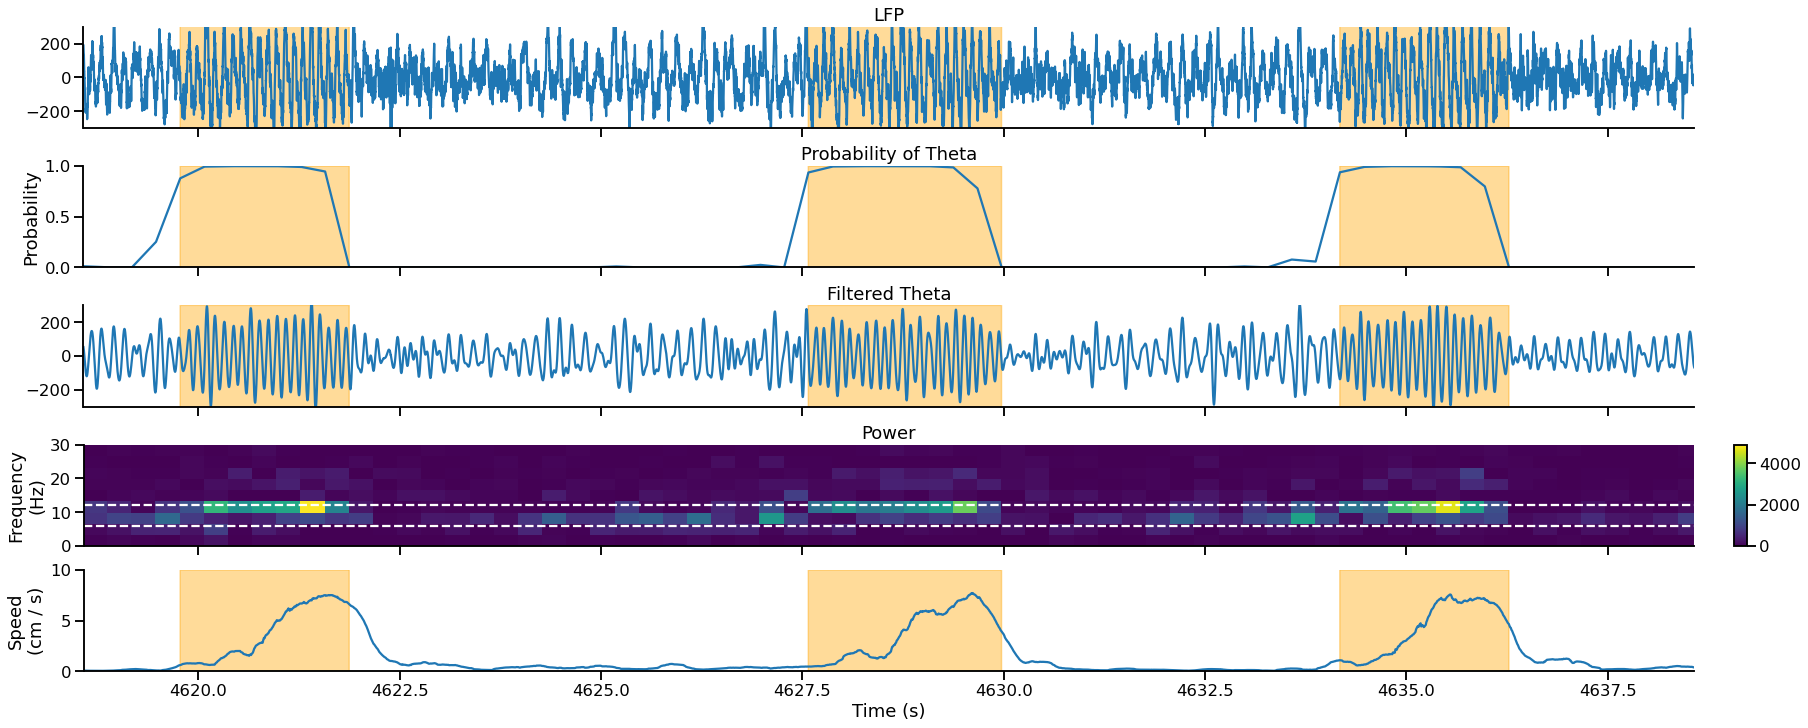

In [18]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 300.0, time.min() + 320.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


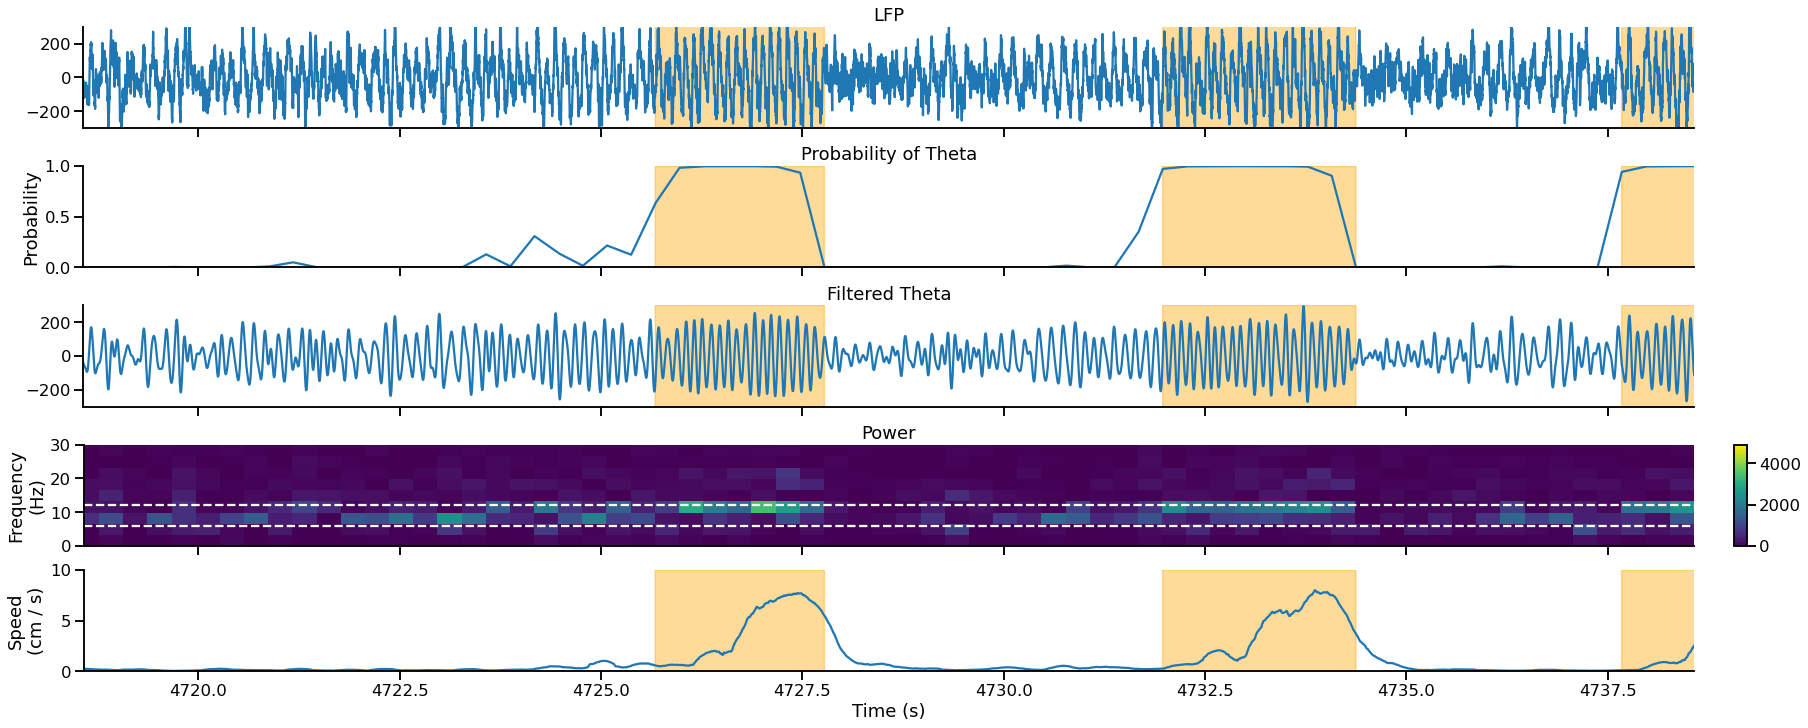

In [19]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min() + 400.0, time.min() + 420.0)

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

/Users/edeno/miniconda3/envs/spectral_rhythm_detector/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


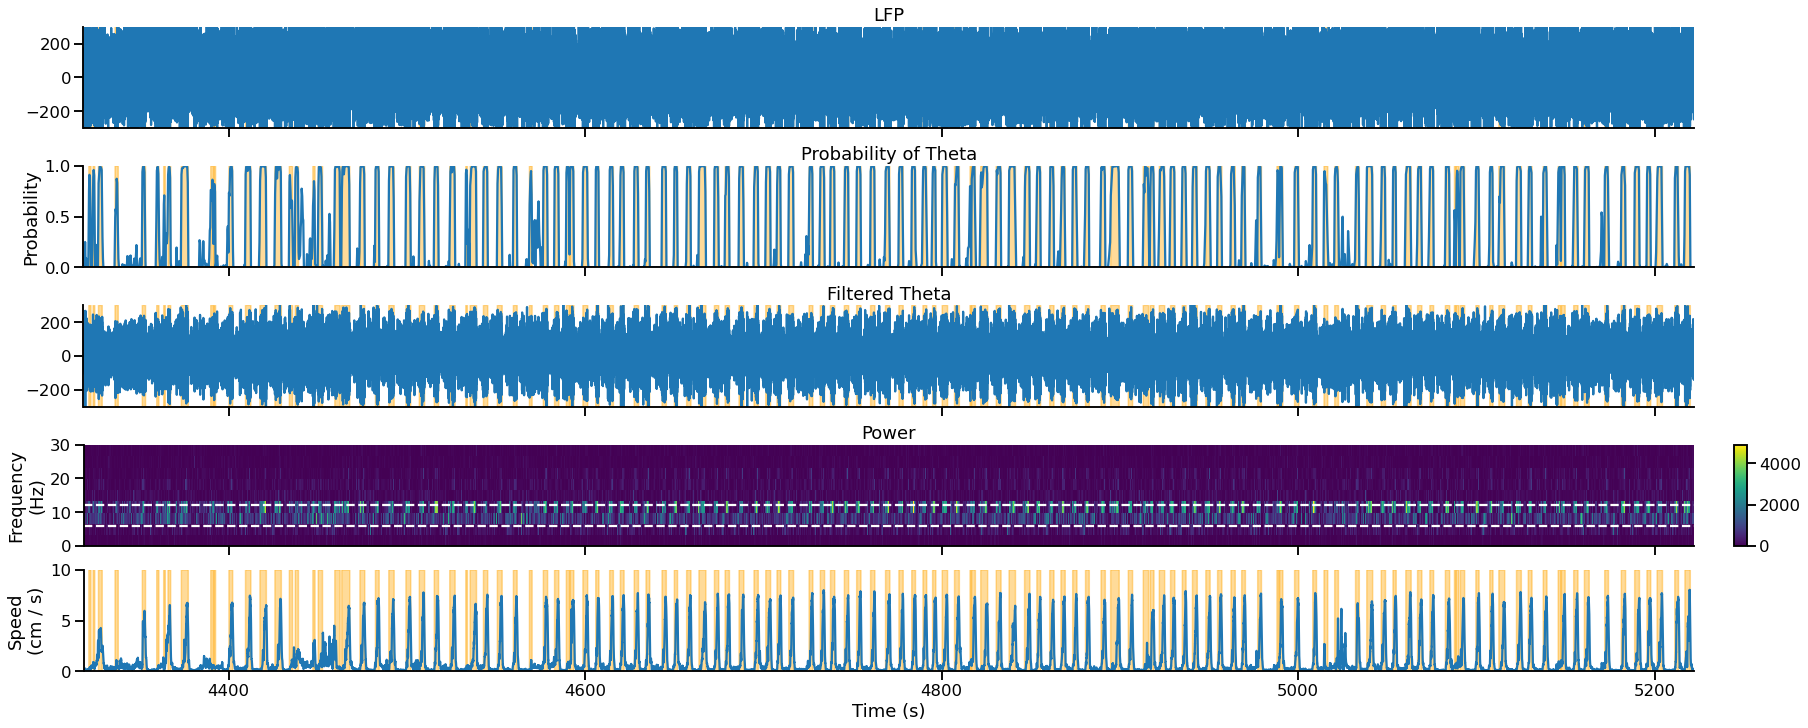

In [20]:
import matplotlib.colors as colors

fig, axes = plt.subplots(5, 1, figsize=(25, 10), sharex=True, constrained_layout=True)

xlim = (time.min(), time.max())

axes[0].plot(time, lfp)
axes[0].set_title('LFP')
axes[0].set_xlim(xlim)
axes[0].fill_between(time, -600, 600, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[0].set_ylim((-300, 300))

axes[1].plot(time, df.probability.values)
axes[1].fill_between(time, 0, 1, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[1].set_xlim(xlim)
axes[1].set_ylabel('Probability')
axes[1].set_title('Probability of Theta')
axes[1].set_ylim((0, 1))

axes[2].plot(time, theta_filtered_lfp)
axes[2].fill_between(time, -300, 300, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[2].set_xlim(xlim)
axes[2].set_ylim((-300, 300))
axes[2].set_title('Filtered Theta')

h = axes[3].pcolormesh(t, f, power.T, vmin=power.min(), vmax=power.max())
axes[3].set_ylabel('Frequency\n(Hz)')
axes[3].set_title('Power')
plt.colorbar(h, ax=axes[3])

axes[3].set_ylim((0, 30));
axes[3].axhline(THETA_BAND[0], linestyle='--', color='white')
axes[3].axhline(THETA_BAND[1], linestyle='--', color='white')
axes[3].set_xlim(xlim)

axes[4].plot(cam_rt_fit_smoothed, tail_velocity)
axes[4].set_ylim((0, 10))
axes[4].set_xlim(xlim)
axes[4].fill_between(time, 0, 10, where=df.is_spectral_rhythm.values, alpha=0.4, color='orange')
axes[4].set_ylabel('Speed\n(cm / s)');

axes[-1].set_xlabel('Time (s)')

sns.despine()

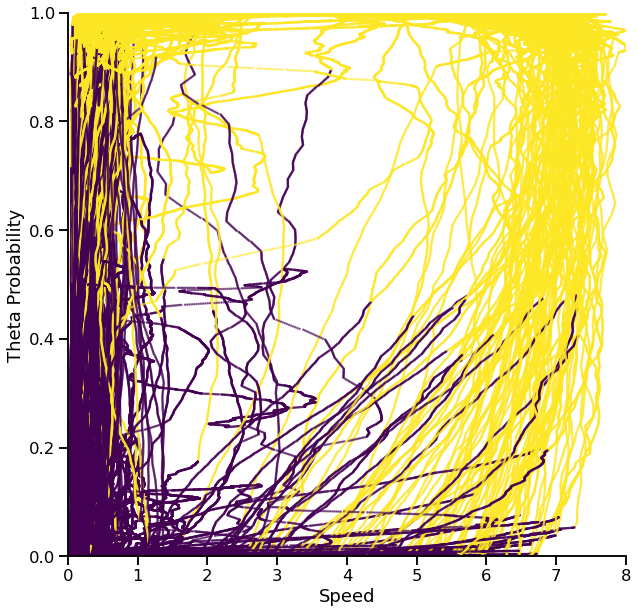

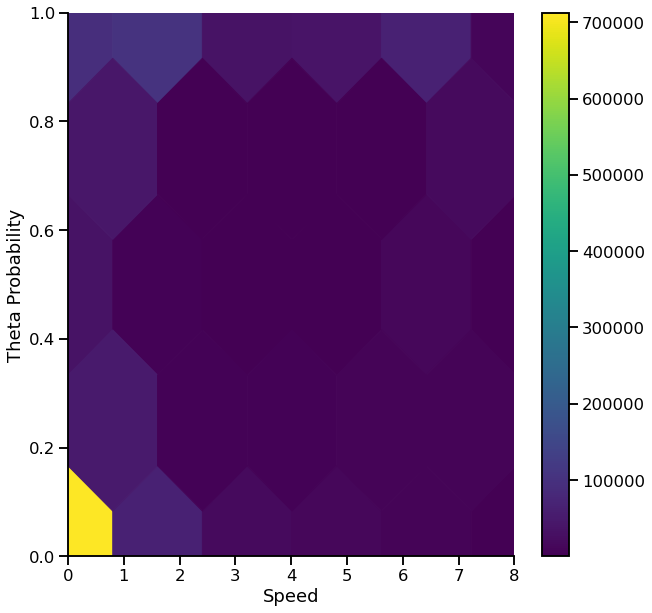

In [21]:
import pandas as pd

tv = pd.Series(tail_velocity.astype(np.float64), index=cam_rt_fit_smoothed, name='tail_velocity')

tv = pd.concat([tv, df.probability], axis=1).sort_index().interpolate().reindex(df.index).tail_velocity
tv[tv < 0] = 0.0

plt.figure(figsize=(10, 10))
plt.scatter(tv.values, df.probability.values, c=df.is_spectral_rhythm, s=1, alpha=0.6)
plt.xlabel('Speed')
plt.ylabel('Theta Probability')
plt.ylim((0, 1))
plt.xlim((0, 8))
sns.despine()

plt.figure(figsize=(10, 10))
plt.hexbin(tv.values, df.probability.values, gridsize=5)
plt.xlabel('Speed')
plt.ylabel('Theta Probability')
plt.ylim((0, 1))
plt.xlim((0, 8))
plt.colorbar()
sns.despine()